### Importing libraries

In [6]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import Counter
from networkx.linalg.graphmatrix import adjacency_matrix

### Data pathes
If assertion fails, download the movielens-100k ratings data from [konect](http://konect.cc/networks/movielens-100k_rating/) and put the files in data/raw.

In [7]:
# Path variables
raw_data_path ="data/raw/"
figure_path = "data/figures/"
bipartite_path = "data/bipartite/"

# Verifying data path
assert os.path.exists(raw_data_path)

def save_figure(path, overwrite=False):
    path = figure_path + path 
    if overwrite:
        plt.savefig(path)
    else:
        if not os.path.exists(path):
            plt.savefig(path)

### Create/load the bipartite network

In [8]:
# Loading movie titles and nodes
with open(raw_data_path+"movie-titles.txt", 'r') as f:
        title_dict =  dict()
        node_dict = dict()
        for line in f.readlines():
            movieid, title = line.strip().split('|')[:2]
            movieid = int(movieid)
            title_dict[movieid] = title
            node_dict[title] = movieid

if os.path.exists(bipartite_path+"full_bipartite.p"):
    with open(bipartite_path+"full_bipartite.p", 'rb') as f:
        G = pickle.load(f)
    print("Graph loaded.")
else:
    G = nx.Graph()

    # Loading edges
    with open(raw_data_path+"rel.rating.csv", 'r') as f:

        for line in f.readlines():
            userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
            userid += 10000
            G.add_node(userid)
            G.add_node(movieid, title=title_dict[movieid])
            G.add_edge(userid, movieid, weight=rating)  # Discarding the timestamp attribute of edges

    # Saving graph as pickle file
    with open(bipartite_path+"full_bipartite.p", 'wb') as f:
        pickle.dump(G, f)
    print("Graph created and saved.")

Graph loaded.


These are summary statistics of the graph from running scripts/metrics.py (removed irrellevant statistics):

#### Basic Statistics
Number of Nodes: 2625, Number of Edges: 100000, Global Density: 0.029, Global Diameter: 5 

####  Degree Statistics
Average Degree: 76.19, Five-Number-Summary Degrees: [  1.,  15.,  42., 106., 737.]

#### Connected Components Statistics
Number of CC: 1, Average CC Size: 2625.0, Average CC Density: 0.029036004645760744}, 

### Weight (Rating) Distribution

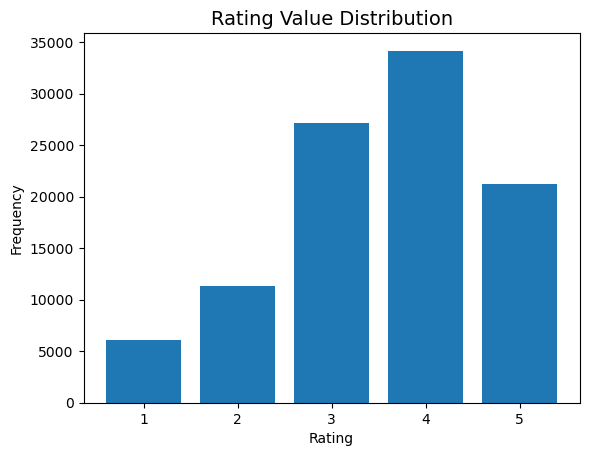

In [9]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)
plt.bar(unique, count)
plt.title("Rating Value Distribution", size=14)
plt.xlabel("Rating")
plt.ylabel("Frequency");
np.mean(weights), np.std(weights)

save_figure("bipartite_rating_value_distribution.png")

### Visualizing Degree Distributions

In [10]:
def plot_ccdf(degree_dictionary, cumulative=True):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   if cumulative:
      ccdf["cumsum"] = ccdf["count"].cumsum()
      ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
      ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

In [11]:
movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

D:\Christian\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


AttributeError: 'Axes' object has no attribute 'is_first_col'

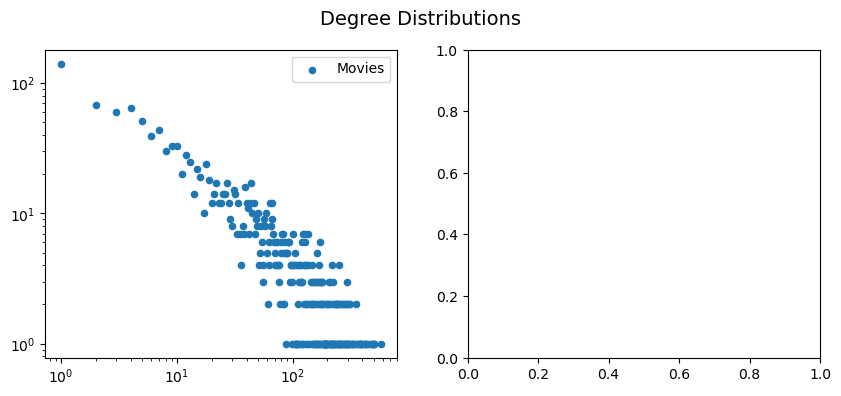

In [12]:
movie_dd = plot_ccdf(movie_degrees, cumulative=False)
user_dd = plot_ccdf(user_degrees, cumulative=False)
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle("Degree Distributions", size=14)
# plt.setp(ax, xlim=(0,1000), ylim=(0,1))
# plt.setp(ax, xlim=ax[0].get_xlim(), ylim=ax[0].get_ylim())
opacity = 1
movie_dd.plot(kind='scatter', x='degree', y='count', loglog=True, label='Movies', ax=ax[0], alpha=opacity, xlabel='Degree', ylabel='Count')
user_dd.plot(kind='scatter', x='degree', y='count', loglog=True, label='Users', ax=ax[1], alpha=opacity, color='C1', ylabel='', xlabel='')                   

# Keeping axis limits consistent and centering xlabel
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].xaxis.set_label_coords(1.1, -0.11)

save_figure("bipartite_dd_movies_and_users.png")

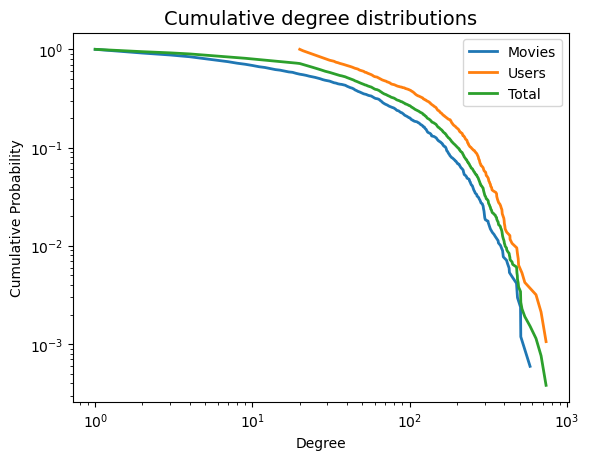

In [13]:
ax = plt.gca()

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)
total_ccdf = plot_ccdf(dict(G.degree()))
            
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movies', ax=ax, linewidth=2)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Users', ax=ax, linewidth=2)
total_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Total', ax=ax, linewidth=2)

ax.set_title("Cumulative degree distributions", size=14)                       
plt.ylabel("Cumulative Probability")
plt.xlabel("Degree")
                       
save_figure("bipartite_ccdf_movies_and_users.png")

In [ ]:
min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'].iloc[0])

The distributions are not power law; they are shifted and there is exponential cutoff. 20 is the obvious minumum of movies rated by any user, since users with fewer than 20 ratings were discarded when making the data set. Some movies on the other hand have very few ratings, the minimum being 1. 44% of movies are rated by 20 or less people.

Add for next time:
add degree distribution plots
summary statistics 
check for power low

### Generate weighted projection and get the degree centrality of both users and movies

In [ ]:
# Split the graph into 2 sets: user and movie nodes
user_nodes, movie_nodes = nx.algorithms.bipartite.basic.sets(G)

# Generate the weighted projections
weighted_projection_users = bipartite.weighted_projected_graph(G, user_nodes)
weighted_projection_movie = bipartite.weighted_projected_graph(G, movie_nodes)

print(weighted_projection_users)
print(weighted_projection_movie)

 Calculate the degree centrality of each user (why are they so high?!) (How many movies each user has rated)

In [ ]:
# How many movies each user has rated
# Compute degree centrality for the users projection
users_degree_centrality = nx.degree_centrality(weighted_projection_users)

# Print the degree centrality for each node in the users projection
print("Degree centrality for users:")
# for node, centrality in users_degree_centrality.items():
    # print(f"Node {node}: {centrality}")


Calculate the degree centrality of each movie (why are they so high?!) (How many ratings per movie)

In [ ]:
# Compute degree centrality for the movie projection
movie_degree_centrality = nx.degree_centrality(weighted_projection_movie)

# Print the degree centrality for each node in the movie projection
print("Degree centrality for movies:")
# for node, centrality in movie_degree_centrality.items():
#     print(f"Node {node}: {centrality}")

The most infuelncial user (max degree centrality), movie popularity (max degree centrality)

In [ ]:
# Find the user with the highest degree centrality
most_influential_user = max(degree_centrality_users, key=degree_centrality_users.get)
centrality_value_user = degree_centrality_users[most_influential_user]

# Add the 1000 to user ID
most_influential_user += 10240

print(f"The most influential user is {most_influential_user} with degree centrality {centrality_value_user}")


# Find the movie with the highest degree centrality
most_rated_movie = max(degree_centrality_movies, key=degree_centrality_movies.get)
centrality_value_movie = degree_centrality_movies[most_rated_movie]

print(f"The most rated movie is {most_rated_movie} with degree centrality {centrality_value_movie}")



Followed Marie's way of getting the projection and it gets the same results, since the reuslts up there were suspicious 

In [ ]:
# Followed Marie's nodes from the exercises to get the degree centrality,since the achieved results looked suspicious.
# Split the graph into 2 sets: user and movie nodes
#user_nodes, movie_nodes = nx.algorithms.bipartite.basic.sets(G)
nodes = nx.algorithms.bipartite.basic.sets(G)

# turn the bipartite network into an adjacency matrix
adjmat_user = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, nodes[1])
adjmat_movie = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, nodes[0])

# we then use the simple weighting method to get the weighted projection 
#projected_users = adjmat_users.dot(adjmat_user.T)
#print(projected_users)
#In your example, the entry (0, 486) 10 
# indicates that user 0 is connected to user 486 with a strength of 10.


projected_movies = adjmat_movies.dot(adjmat_movies.T) 

#Create weighted graphs from the weighted adjacency matrices
#G_users = nx.Graph(projected_users)
G_movies = nx.Graph(projected_movies)

# Step 2: Calculate degree centrality for users and movies
#degree_centrality_users = nx.degree_centrality(G_users)
degree_centrality_movies = nx.degree_centrality(G_movies)

# Print the degree centrality for users
#for user, centrality in degree_centrality_users.items():
    #print(f"User {user} has degree centrality: {centrality}")

# Print the degree centrality for movies
# for movie, centrality in degree_centrality_movies.items():
#     print(f"Movie {movie} has degree centrality: {centrality}")


### Research Question

Feed

#### Idea for an algorithm where projections take ratings into account in some way:
1. Get input of movies you like, M, which have ratings by users U
2. Project U and M onto U to get U1
3. Project U1, and all movies they rated, onto the movies to get M1
4. Recommend, from M1, the highest weight neighbor(s) of M.
#### How to recommend movies based on user ratings, given a list of liked movies?

* Potential problem: if our sample of users is too large, we are likely to just recommend the most rated movies, not specific movies you would like. To test this, we could plot correlation between movie degree and likelihood to recommend.

* Sample users who liked the movie(s), project onto their rated movies, recommend highest weight neighbor of liked movies.

* Construct similar movies to the ones you like, use this to find users like you, and iterate to converge on movies you will like.

* Evaluation metric: For a sample of users, sampling their liked movies, how likely are we to recommend another movie that they like (reviewed highly)?

* How to take movie genre into account?

* Does the recommend movie graph have high genre homophily?
* Can we take liked genre(s) as input?


#### How to take mov
#### Do users like movies from one genre or movies of different genres?

In [ ]:
# To build directed movie recommendation graph:
# For each movie u
#    For each other movie v
#       Compute rating resource allocation weight from u to v
#       add it as directed edge (u,v)

dir_movie_graph = nx.DiGraph()
for u in movie_nodes:
    degree_u = G.degree(u)
    for v in movie_nodes:

        # Prevent self-loops
        if v == u:
            continue
        
        # Find intersection of neighborhood sets
        N_u = G.neighbors(u)
        N_v = G.neighbors(v)
        N_u_v = set(N_u) & set(N_v)

        # Computing the weight from u to v according to rating allocation
        weight_u_v = 0
        for n in N_u_v:
            w_u_n = G.get_edge_data(u,n)['weight']
            w_n_v = G.get_edge_data(n,v)['weight']
            weight_u_v += w_u_n / degree_u * w_n_v / G.degree(n)

        dir_movie_graph.add_edge(u, v, weight=weight_u_v)

# TODO: Save and load graph
    

In [ ]:
# To recommend, find highest weight movie from movie you like

def k_highest_weight_neighbors(k, liked_movie_title, graph):
    
    liked_movie_node = node_dict[liked_movie_title]
    edges = list(graph.edges(liked_movie_node, data=True))
    
    neighbors_weights = [(neighbor, weight['weight']) for node, neighbor, weight in edges]
    neighbors_weights = sorted(neighbors_weights, reverse=True, key=lambda x: x[1])

    n_neighbors = [(title_dict[neighbor],weight) for neighbor, weight in neighbors_weights][:k]

    print(f"{k} highest weight neighbors of '{liked_movie_title}':")
    return n_neighbors

k_highest_weight_neighbors(10, 'Die Hard (1988)', dir_movie_graph)

In [ ]:
# For multiple likes movies, find highest average weight movie
